# LIBRARIES, DATA, AND PREPROCESSING

## Librairies

In [65]:
import sys
print(sys.executable)
!{sys.executable} -m pip install yfinance
import yfinance as yf
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

plt.style.use("seaborn-v0_8")


c:\Users\Emile\anaconda3\python.exe


## Import Data + CSV generation

In [66]:
tickers = {
    "DJ30": "^DJI",     # Dow Jones Industrial Average
    "SNP500": "^GSPC",  # S&P 500 Index
    "CAC40": "^FCHI"    # CAC 40 Index
}
start_date = "2018-01-01"
end_date = "2025-01-01"

for name, symbol in tickers.items():
    # Download data
    data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
    
    # Rename columns with prefix, e.g. "CAC40_Open", "CAC40_Close", etc.
    data = data.rename(columns={col: f"{name}__{col}" for col in data.columns})
    
    # Save to CSV
    filename = f"{name}_data.csv"
    data.to_csv(filename, index=True)
    print(data.head(), "\n")


C:\Users\Emile\AppData\Local\Temp\ipykernel_30620\4262377256.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
[*********************100%***********************]  1 of 1 completed
C:\Users\Emile\AppData\Local\Temp\ipykernel_30620\4262377256.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
[*********************100%***********************]  1 of 1 completed
C:\Users\Emile\AppData\Local\Temp\ipykernel_30620\4262377256.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
[*********************100%***********************]  1 of 1 completed

Price               Open          High           Low         Close     Volume
Ticker              ^DJI          ^DJI          ^DJI          ^DJI       ^DJI
Date                                                                         
2018-01-02  24809.349609  24864.189453  24741.699219  24824.009766  341130000
2018-01-03  24850.449219  24941.919922  24825.550781  24922.679688  456790000
2018-01-04  24964.859375  25105.960938  24963.269531  25075.130859  403280000
2018-01-05  25114.919922  25299.789062  25112.009766  25295.869141  358020000
2018-01-08  25308.400391  25311.990234  25235.410156  25283.000000  341390000 

Price              Open         High          Low        Close      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2018-01-02  2683.729980  2695.889893  2682.360107  2695.810059  3397430000
2018-01-03  2697.850098  2714.370117  2697.770020  2713.060059  3544030000

## DATA PREPROCESSING

In [67]:
df_sp = pd.read_csv("SNP500_data.csv")

# Deleting useless columns
df_sp = df_sp[~df_sp["Price"].isin(["Ticker", "Date"])].copy()

#The "price" collumn are actuallt dates
df_sp["Date"] = pd.to_datetime(df_sp["Price"])
df_sp = df_sp.drop(columns=["Price"])
df_sp = df_sp.set_index("Date")

#Make sure that every column has numerical values
for col in df_sp.columns:
    df_sp[col] = pd.to_numeric(df_sp[col], errors="coerce")

print(df_sp.head())
print(df_sp.info())

                   Open         High          Low        Close      Volume
Date                                                                      
2018-01-02  2683.729980  2695.889893  2682.360107  2695.810059  3397430000
2018-01-03  2697.850098  2714.370117  2697.770020  2713.060059  3544030000
2018-01-04  2719.310059  2729.290039  2719.070068  2723.989990  3697340000
2018-01-05  2731.330078  2743.449951  2727.919922  2743.149902  3239280000
2018-01-08  2742.669922  2748.510010  2737.600098  2747.709961  3246160000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1761 non-null   float64
 1   High    1761 non-null   float64
 2   Low     1761 non-null   float64
 3   Close   1761 non-null   float64
 4   Volume  1761 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.5 KB
None


In [68]:
#creating a copy on which we will work
data = df_sp.copy()

# returns
data["return_1d"] = data["Close"].pct_change()

# target: next day's return
data["target_return_1d"] = data["return_1d"].shift(-1)

# classification if the return is > 0 or not
data["target_direction"] = (data["target_return_1d"] > 0).astype(int)

# cleaning: remove NaN due to shifts
data = data.dropna()

# final preview
print("\nFinal dataset preview:")
display(data.head())


print("\nFinal shape:", data.shape)


Final dataset preview:


,Open,High,Low,Close,Volume,return_1d,target_return_1d,target_direction
Date,,,,,,,,
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,3544030000,0.006399,0.004029,1
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,3697340000,0.004029,0.007034,1
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,3239280000,0.007034,0.001662,1
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,3246160000,0.001662,0.001303,1
2018-01-09,2751.149902,2759.139893,2747.860107,2751.290039,3467460000,0.001303,-0.001112,0



Final shape: (1759, 8)


## SPLITTING DATA

We will split  our data in the following way :

2015–2019 → Train
2020–2022 → Validation
2023–2024 → Test


# INDICATORS

- In this section, we will create the folloiwing indicators in order to apply them to the DJ30, SNP500 and CAC40 historical data :
    - MACD
    - RSI
    - Moving Averages
    - Volumes
    - Momentum

## MACD

What is the MACD?

The Moving Average Convergence Divergence (MACD) is a **momentum indicator**
used in technical analysis to reveal changes in the strength, direction,
and duration of a trend in a stock’s price. It’s calculated as the difference
between two Exponential Moving Averages (EMAs): a short-term one (usually 12 periods)
and a long-term one (usually 26 periods). 

    The MACD line = EMA(12) – EMA(26)
    The Signal line = EMA(9) of the MACD line
    The Histogram = MACD – Signal

When the MACD crosses above the Signal line, it may indicate **bullish momentum**;
when it crosses below, it may suggest **bearish momentum**.

In [69]:
def compute_MACD(series, fast=12, slow=26, signal=9):
    """
    Compute MACD (Moving Average Convergence Divergence) indicator.
    Returns:
        macd_line, signal_line, macd_histogram
    """
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()

    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_line

    return macd_line, signal_line, macd_hist

#calculate MACD on close prices
data["MACD_line"], data["MACD_signal"], data["MACD_hist"] = compute_MACD(data["Close"])

#no look-ahead bias
data["MACD_line"]   = data["MACD_line"].shift(1)
data["MACD_signal"] = data["MACD_signal"].shift(1)
data["MACD_hist"]   = data["MACD_hist"].shift(1)

#clean NaN
data = data.dropna()

display(data[["Close", "MACD_line", "MACD_signal", "MACD_hist"]].head())

,Close,MACD_line,MACD_signal,MACD_hist
Date,,,,
2018-01-04,2723.989990,0.000000,0.000000,0.000000
2018-01-05,2743.149902,0.871903,0.174381,0.697523
2018-01-08,2747.709961,3.073508,0.754206,2.319302
2018-01-09,2751.290039,5.127152,1.628795,3.498357
2018-01-10,2748.229980,6.963294,2.695695,4.267599


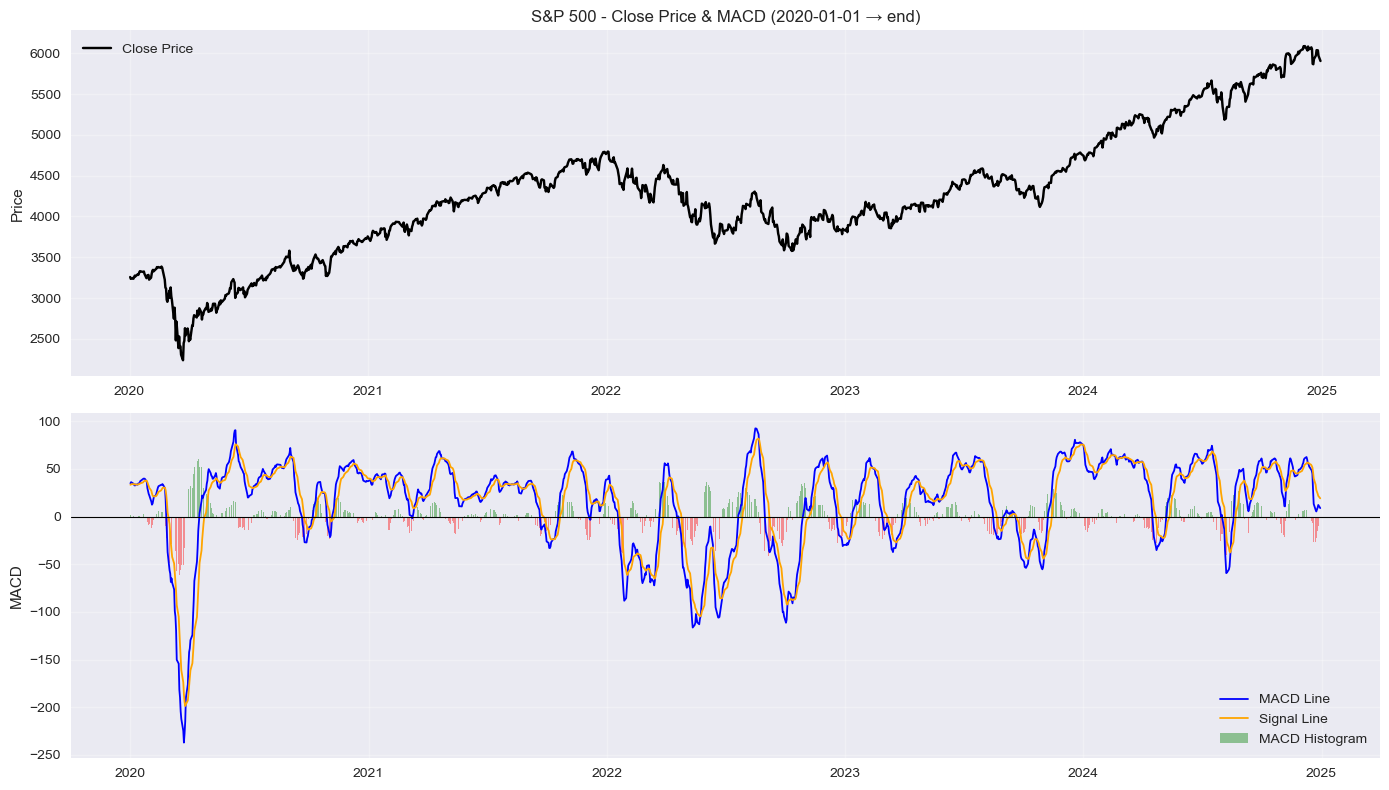

In [70]:
import matplotlib.pyplot as plt

start_plot = "2020-01-01"
data_plot = data.loc[start_plot:]

plt.figure(figsize=(14, 8))

# --- 1) Plot du prix ---
plt.subplot(2, 1, 1)
plt.plot(data_plot.index, data_plot["Close"], label="Close Price", color="black")
plt.title(f"S&P 500 - Close Price & MACD ({start_plot} → end)")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend()

# --- 2) Plot du MACD ---
plt.subplot(2, 1, 2)
plt.plot(data_plot.index, data_plot["MACD_line"], label="MACD Line", color="blue", linewidth=1.3)
plt.plot(data_plot.index, data_plot["MACD_signal"], label="Signal Line", color="orange", linewidth=1.3)

# Histogram
plt.bar(
    data_plot.index,
    data_plot["MACD_hist"],
    label="MACD Histogram",
    color=["green" if v >= 0 else "red" for v in data_plot["MACD_hist"]],
    alpha=0.4
)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("MACD")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


## RSI

The Relative Strength Index (RSI) is a momentum oscillator developed by J. Welles Wilder that measures the speed and magnitude of recent price movements to identify overbought or oversold market conditions. It oscillates between 0 and 100, typically using a 14-period window. When RSI rises above 70, it suggests that the asset may be overbought and could experience a pullback; when it falls below 30, it indicates that the asset may be oversold and due for a rebound. In trading and machine-learning contexts, RSI serves as a non-linear feature capturing momentum reversals and exhaustion in trends—helping models detect short-term shifts in market sentiment.

In [71]:
def compute_RSI(series, window=14):
    delta = series.diff()

    # Separate positive and negative changes
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Exponential moving averages (Wilder’s smoothing)
    avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [72]:
data["RSI_14"] = compute_RSI(data["Close"], window=14)

In [73]:
data["RSI_14"] = data["RSI_14"].shift(1)
#to prevent look ahead bias

#clean missing values
data = data.dropna()

display(data[["Close", "RSI_14"]].head())

,Close,RSI_14
Date,,
2018-01-26,2872.870117,87.329050
2018-01-29,2853.530029,90.853112
2018-01-30,2822.429932,77.500066
2018-01-31,2823.810059,61.776478
2018-02-01,2821.979980,62.143533


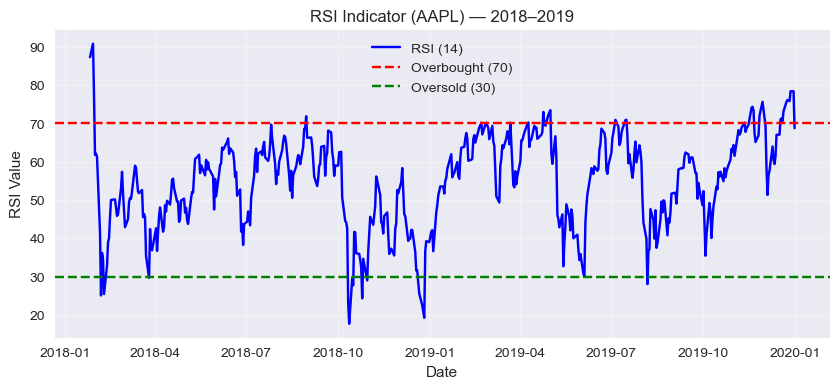

In [74]:
mask = (data.index >= "2018-01-01") & (data.index <= "2019-12-31")
subset = data.loc[mask]
plt.figure(figsize=(10, 4))
plt.plot(subset.index, subset["RSI_14"], label="RSI (14)", color="blue")
plt.axhline(70, color="red", linestyle="--", label="Overbought (70)")
plt.axhline(30, color="green", linestyle="--", label="Oversold (30)")
plt.title("RSI Indicator (AAPL) — 2018–2019")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## EMA

Moving averages smooth the price and help identify trends,the EMA applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. Momentum measures how quickly the price changes over a period (10 or 20 days).
Positive momentum means acceleration upward, negative momentum means downward acceleration.

In [75]:
#Simple Moving Averages
data["SMA_20"] = data["Close"].rolling(window=20).mean()
data["SMA_50"] = data["Close"].rolling(window=50).mean()

#Exponential Moving Average (EMA)
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()

In [76]:
#difference between price and moving averages
data["Close_minus_SMA20"] = data["Close"] - data["SMA_20"]
data["Close_minus_SMA50"] = data["Close"] - data["SMA_50"]

In [77]:
#momentum indicators
data["momentum_10d"] = data["Close"].pct_change(10)
data["momentum_20d"] = data["Close"].pct_change(20)

In [78]:
#no look ahead bias
cols_to_shift = [
    "SMA_20", "SMA_50", "EMA_20",
    "Close_minus_SMA20", "Close_minus_SMA50",
    "momentum_10d", "momentum_20d"
]

data[cols_to_shift] = data[cols_to_shift].shift(1)

#clean NaN
data = data.dropna()

In [79]:
display(data[[
    "Close", "SMA_20", "SMA_50", "EMA_20",
    "Close_minus_SMA20", "momentum_10d", "momentum_20d"
]].head())

,Close,SMA_20,SMA_50,EMA_20,Close_minus_SMA20,momentum_10d,momentum_20d
Date,,,,,,,
2018-04-10,2656.870117,2670.470996,2705.006597,2656.475075,-57.311084,0.009620,-0.062231
2018-04-11,2642.189941,2664.163501,2700.686597,2656.512698,-7.293384,-0.000632,-0.045328
2018-04-12,2663.989990,2658.007495,2696.459795,2655.148626,-15.817554,0.011318,-0.044523
2018-04-13,2656.300049,2653.732996,2693.290996,2655.990661,10.256995,0.022645,-0.031093
2018-04-16,2677.840088,2649.181494,2689.940796,2656.020126,7.118555,0.005843,-0.033134


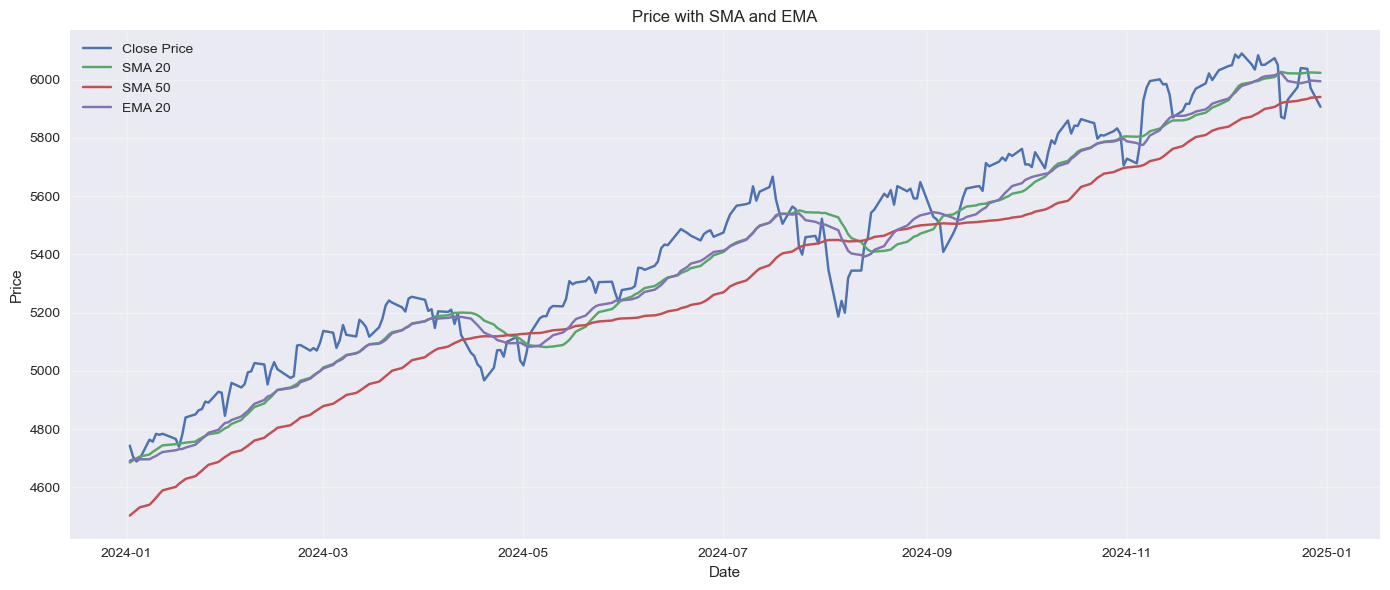

In [80]:
start_plot = "2024-01-01"
plot_data = data.loc[start_plot:]

plt.figure(figsize=(14, 6))

plt.plot(plot_data.index, plot_data["Close"], label="Close Price")
plt.plot(plot_data.index, plot_data["SMA_20"], label="SMA 20")
plt.plot(plot_data.index, plot_data["SMA_50"], label="SMA 50")
plt.plot(plot_data.index, plot_data["EMA_20"], label="EMA 20")

plt.title("Price with SMA and EMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

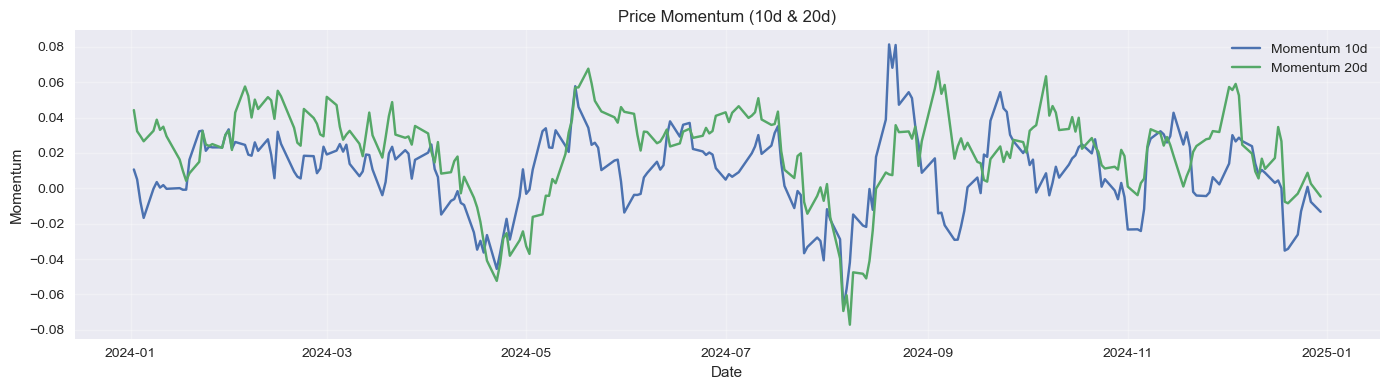

In [81]:
plt.figure(figsize=(14, 4))

plt.plot(plot_data.index, plot_data["momentum_10d"], label="Momentum 10d")
plt.plot(plot_data.index, plot_data["momentum_20d"], label="Momentum 20d")

plt.title("Price Momentum (10d & 20d)")
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

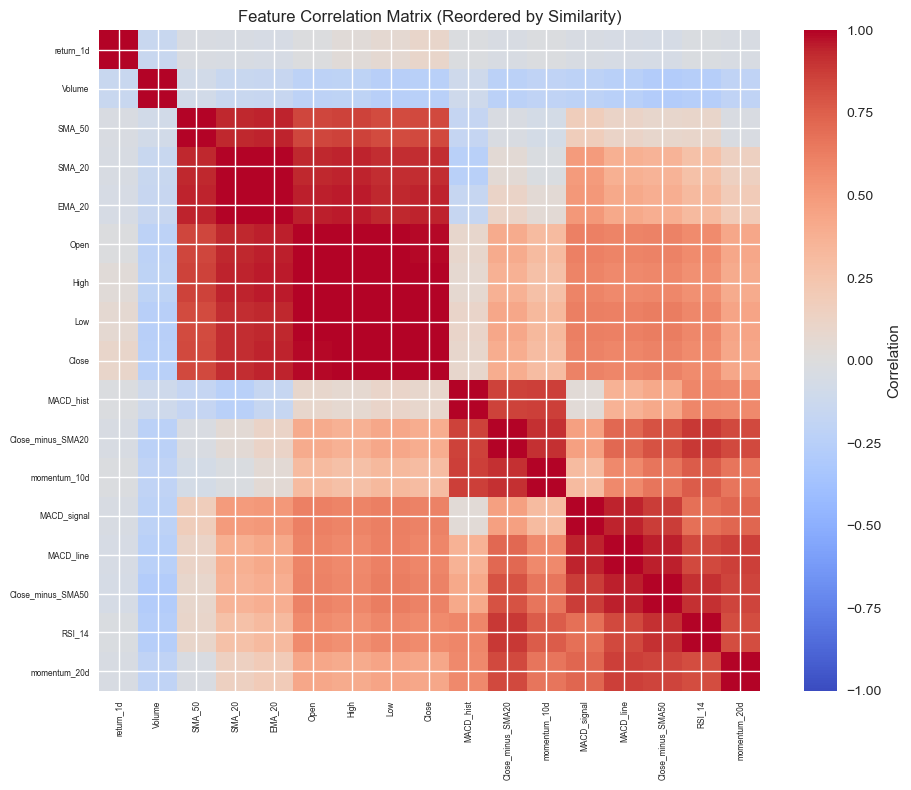

In [ ]:
# Correlation matrix (train set)
exclude = {"target_direction", "target_return_1d"}
corr_features = [
    c for c in train_df.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(train_df[c])
]

corr = train_df[corr_features].corr()

# Hierarchical clustering on correlations
# Distance based on absolute correlation
dist = 1 - np.abs(corr)

# Convert to condensed distance matrix
dist_condensed = squareform(dist.values)

# Linkage
Z = linkage(dist_condensed, method="average")

# Order features
order = leaves_list(Z)
ordered_features = [corr_features[i] for i in order]

# Reorder correlation matrix
corr_ordered = corr.loc[ordered_features, ordered_features]

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(corr_ordered, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.title("Feature Correlation Matrix (Reordered by Similarity)")
plt.xticks(range(len(ordered_features)), ordered_features, rotation=90, fontsize=6)
plt.yticks(range(len(ordered_features)), ordered_features, fontsize=6)
plt.tight_layout()
plt.show()


## Modeling — Baseline Classification (Logistic Regression)

This section builds an **interpretable baseline** classifier to predict the **next-day direction** of returns:
- `target_direction = 1` if next-day return is positive, else `0`.

A **time-aware split** is used (no shuffling) to mimic an out-of-sample evaluation.
All preprocessing is handled through a **Pipeline** to avoid leakage (scaling is fitted on the train set only).


Split sizes: {'train': 436, 'val': 756, 'test': 501}
X shapes: (436, 17) (756, 17) (501, 17)
Train class balance: {1: 0.5596330275229358, 0: 0.44036697247706424}

[Logistic Regression — Validation]
Train time: 0.0072s | Inference time: 0.0017s
Accuracy: 0.5093 | Precision: 0.5229 | Recall: 0.6937 | F1: 0.5963

Classification report (validation):
              precision    recall  f1-score   support

           0       0.48      0.31      0.37       361
           1       0.52      0.69      0.60       395

    accuracy                           0.51       756
   macro avg       0.50      0.50      0.49       756
weighted avg       0.50      0.51      0.49       756



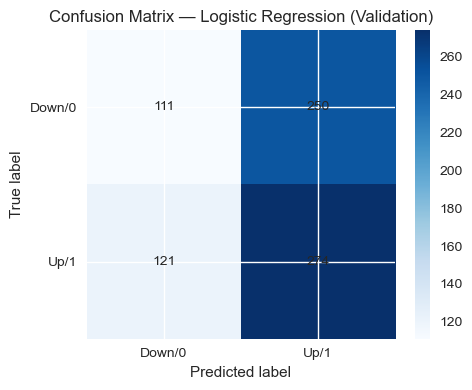


Top 15 features by |coefficient| (standardized space):


,feature,coef,abs_coef
13,Close_minus_SMA20,0.303717,0.303717
0,Open,-0.275784,0.275784
1,High,-0.274744,0.274744
11,SMA_50,0.251307,0.251307
9,RSI_14,-0.225176,0.225176
6,MACD_line,0.166906,0.166906
12,EMA_20,0.139218,0.139218
7,MACD_signal,0.134535,0.134535
8,MACD_hist,0.125620,0.125620
4,Volume,-0.123215,0.123215


In [83]:
#Data and target checks
if "data" not in globals():
    raise NameError("Expected a dataframe named `data` (created earlier in the notebook).")

if "target_direction" not in data.columns:
    raise KeyError("Column `target_direction` not found in `data`. It must be created before modeling.")

# Ensure time index is sorted
data = data.sort_index()


# 1) Time-aware split
# Train: 2015–2019
# Validation: 2020–2022
# Test: 2023–2024
train_df = data.loc["2015-01-01":"2019-12-31"].copy()
val_df   = data.loc["2020-01-01":"2022-12-31"].copy()
test_df  = data.loc["2023-01-01":"2024-12-31"].copy()

# Fallback if a dataset starts later (keeps the same logic: most data for training)
if len(train_df) == 0 or len(val_df) == 0 or len(test_df) == 0:
    n = len(data)
    train_end = int(n * 0.80)
    val_end = int(n * 0.90)
    train_df = data.iloc[:train_end].copy()
    val_df   = data.iloc[train_end:val_end].copy()
    test_df  = data.iloc[val_end:].copy()

print("Split sizes:", {"train": len(train_df), "val": len(val_df), "test": len(test_df)})


# 2) Feature matrix (X) and target vector (y)
# Exclude targets (and keep all remaining numeric columns as features).
exclude_cols = {"target_direction", "target_return_1d"}

feature_cols = [
    c for c in train_df.columns
    if c not in exclude_cols and pd.api.types.is_numeric_dtype(train_df[c])
]

# Basic sanity check: all features must exist in all splits
missing_in_val = [c for c in feature_cols if c not in val_df.columns]
missing_in_test = [c for c in feature_cols if c not in test_df.columns]
if missing_in_val or missing_in_test:
    raise KeyError(
        f"Some features are missing in validation/test sets. "
        f"Missing in val: {missing_in_val[:10]} | Missing in test: {missing_in_test[:10]}"
    )

X_train = train_df[feature_cols]
y_train = train_df["target_direction"].astype(int)

X_val = val_df[feature_cols]
y_val = val_df["target_direction"].astype(int)

X_test = test_df[feature_cols]
y_test = test_df["target_direction"].astype(int)

print("X shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Train class balance:", y_train.value_counts(normalize=True).to_dict())


# 3) Pipeline (scaling + classifier)
logreg_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])


# 4) Fit on train, evaluate on validation
t0 = time.perf_counter()
logreg_pipe.fit(X_train, y_train)
train_time = time.perf_counter() - t0

t1 = time.perf_counter()
y_val_pred = logreg_pipe.predict(X_val)
infer_time = time.perf_counter() - t1

acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

print("\n[Logistic Regression — Validation]")
print(f"Train time: {train_time:.4f}s | Inference time: {infer_time:.4f}s")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred, zero_division=0))


# 5) Confusion matrix (validation)
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix — Logistic Regression (Validation)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Down/0", "Up/1"])
plt.yticks([0, 1], ["Down/0", "Up/1"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


# 6) Coefficients (feature influence in standardized space)
coefs = logreg_pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_cols, "coef": coefs, "abs_coef": np.abs(coefs)})
coef_df = coef_df.sort_values("abs_coef", ascending=False)

print("\nTop 15 features by |coefficient| (standardized space):")
display(coef_df.head(15))


# Classification — Decision Tree (Non-linear baseline)

Shapes: (436, 17) (756, 17)
Train class balance: {1: 0.5596330275229358, 0: 0.44036697247706424}

[Decision Tree — Default (Validation)]
Train time: 0.0174s | Inference time: 0.0012s
Accuracy: 0.5079 | Precision: 0.5319 | Recall: 0.4861 | F1: 0.5079

Classification report:
               precision    recall  f1-score   support

           0       0.49      0.53      0.51       361
           1       0.53      0.49      0.51       395

    accuracy                           0.51       756
   macro avg       0.51      0.51      0.51       756
weighted avg       0.51      0.51      0.51       756



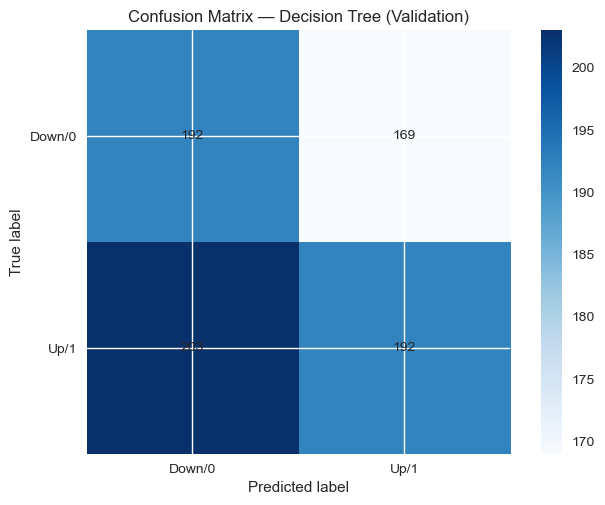

,max_depth,train_acc,val_acc,train_f1,val_f1
0,1,0.582569,0.503968,0.717391,0.556213
1,2,0.584862,0.498677,0.727820,0.626601
2,3,0.635321,0.502646,0.736318,0.577528
3,4,0.665138,0.497354,0.764516,0.628906
4,5,0.678899,0.503968,0.773463,0.629080
5,7,0.738532,0.500000,0.788889,0.434132
6,10,0.848624,0.498677,0.871094,0.512227
7,15,0.928899,0.497354,0.940039,0.515306
8,None,1.000000,0.507937,1.000000,0.507937


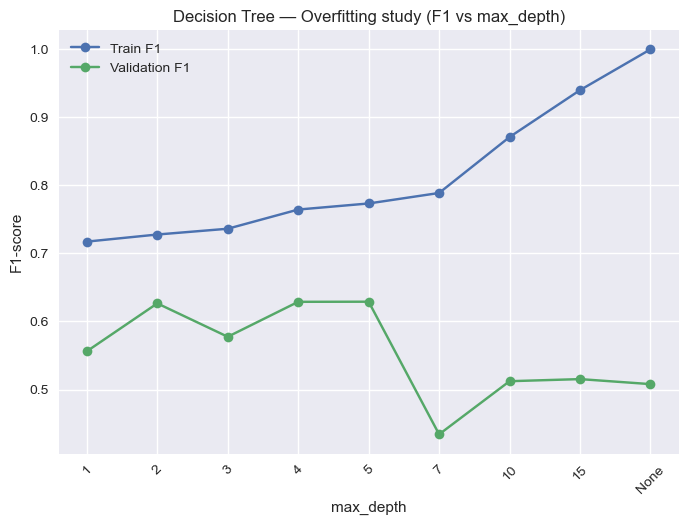


Best depth by validation F1:
max_depth           5
train_acc    0.678899
val_acc      0.503968
train_f1     0.773463
val_f1        0.62908
Name: 4, dtype: object


In [84]:
# Reuse the exact same split + features as Logistic Regression
# Expected: DF dataframe + feature_cols list + target column name TARGET

if "DF" not in globals():
    if "df_model" in globals():
        DF = df_model.copy()
    elif "data" in globals():
        DF = data.copy()
    else:
        raise NameError("Could not find modeling dataframe (`df_model` or `data`).")

TARGET = "target_direction"
if TARGET not in DF.columns:
    raise KeyError(f"Target column `{TARGET}` not found.")

if "feature_cols" not in globals():
    exclude = {TARGET, "target_return_1d"}
    feature_cols = [c for c in DF.columns if c not in exclude and pd.api.types.is_numeric_dtype(DF[c])]

if not all(name in globals() for name in ["train_df", "val_df", "test_df"]):
    n = len(DF)
    train_end = int(n * 0.80)
    val_end   = int(n * 0.90)
    train_df = DF.iloc[:train_end].copy()
    val_df   = DF.iloc[train_end:val_end].copy()
    test_df  = DF.iloc[val_end:].copy()

X_train = train_df[feature_cols]
y_train = train_df[TARGET].astype(int)

X_val = val_df[feature_cols]
y_val = val_df[TARGET].astype(int)

print("Shapes:", X_train.shape, X_val.shape)
print("Train class balance:", y_train.value_counts(normalize=True).to_dict())



# Default Decision Tree (baseline)
dt_default = DecisionTreeClassifier(random_state=42)

t0 = time.perf_counter()
dt_default.fit(X_train, y_train)
train_time = time.perf_counter() - t0

t1 = time.perf_counter()
y_val_pred = dt_default.predict(X_val)
infer_time = time.perf_counter() - t1

acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

print("\n[Decision Tree — Default (Validation)]")
print(f"Train time: {train_time:.4f}s | Inference time: {infer_time:.4f}s")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_val, y_val_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Decision Tree (Validation)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Down/0", "Up/1"])
plt.yticks([0, 1], ["Down/0", "Up/1"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()


# Overfitting study: max_depth sweep
depths = [1, 2, 3, 4, 5, 7, 10, 15, None]
rows = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)

    y_tr = model.predict(X_train)
    y_va = model.predict(X_val)

    rows.append({
        "max_depth": str(d),
        "train_acc": accuracy_score(y_train, y_tr),
        "val_acc": accuracy_score(y_val, y_va),
        "train_f1": f1_score(y_train, y_tr, zero_division=0),
        "val_f1": f1_score(y_val, y_va, zero_division=0),
    })

results_dt = pd.DataFrame(rows)
display(results_dt)

# Plot train vs validation
plt.figure()
plt.plot(results_dt["max_depth"], results_dt["train_f1"], marker="o", label="Train F1")
plt.plot(results_dt["max_depth"], results_dt["val_f1"], marker="o", label="Validation F1")
plt.title("Decision Tree — Overfitting study (F1 vs max_depth)")
plt.xlabel("max_depth")
plt.ylabel("F1-score")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Choose the best depth based on validation F1
best_row = results_dt.loc[results_dt["val_f1"].idxmax()]
print("\nBest depth by validation F1:")
print(best_row)


# Classification — Random Forest (Ensemble Model)

Shapes: (436, 17) (756, 17)
Train class balance: {1: 0.5596330275229358, 0: 0.44036697247706424}

[Random Forest — Baseline (Validation)]
Train time: 0.3619s | Inference time: 0.0365s
Accuracy: 0.5132 | Precision: 0.5318 | Recall: 0.5722 | F1: 0.5512

Classification report:
               precision    recall  f1-score   support

           0       0.49      0.45      0.47       361
           1       0.53      0.57      0.55       395

    accuracy                           0.51       756
   macro avg       0.51      0.51      0.51       756
weighted avg       0.51      0.51      0.51       756



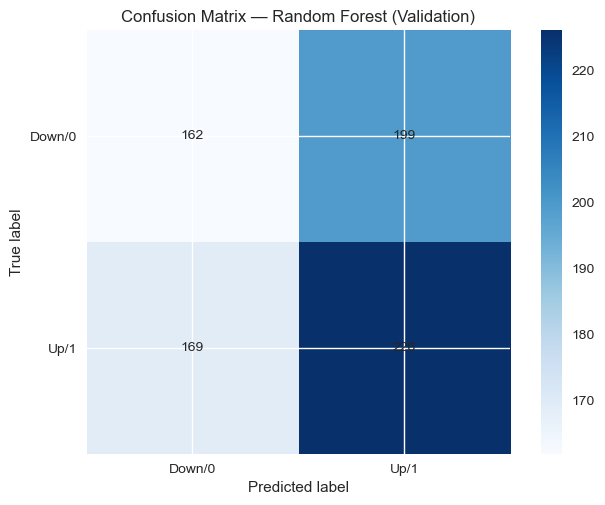


Top 10 configurations by validation F1:


,n_estimators,max_depth,min_samples_leaf,val_accuracy,val_precision,val_recall,val_f1
14,500,3,20,0.525132,0.524064,0.992405,0.685914
23,500,None,20,0.522487,0.522973,0.979747,0.681938
20,500,10,20,0.522487,0.522973,0.979747,0.681938
17,500,5,20,0.521164,0.522327,0.977215,0.680776
2,200,3,20,0.521164,0.522449,0.972152,0.679646
8,200,10,20,0.519841,0.521918,0.964557,0.677333
11,200,None,20,0.519841,0.521918,0.964557,0.677333
5,200,5,20,0.517196,0.520661,0.956962,0.674398
13,500,3,5,0.509259,0.517544,0.896203,0.656163
1,200,3,5,0.506614,0.516768,0.858228,0.645100



Best configuration (by validation F1): {'n_estimators': 500, 'max_depth': '3', 'min_samples_leaf': 20, 'val_accuracy': 0.5251322751322751, 'val_precision': 0.5240641711229946, 'val_recall': 0.9924050632911392, 'val_f1': 0.6859142607174104}

Best RF validation F1 (retrained): 0.6859

Top 20 features by Random Forest importance:


,feature,importance
9,RSI_14,0.082504
14,Close_minus_SMA50,0.082188
13,Close_minus_SMA20,0.081774
11,SMA_50,0.075490
4,Volume,0.064035
3,Close,0.059595
2,Low,0.057522
1,High,0.055867
0,Open,0.055600
6,MACD_line,0.053046


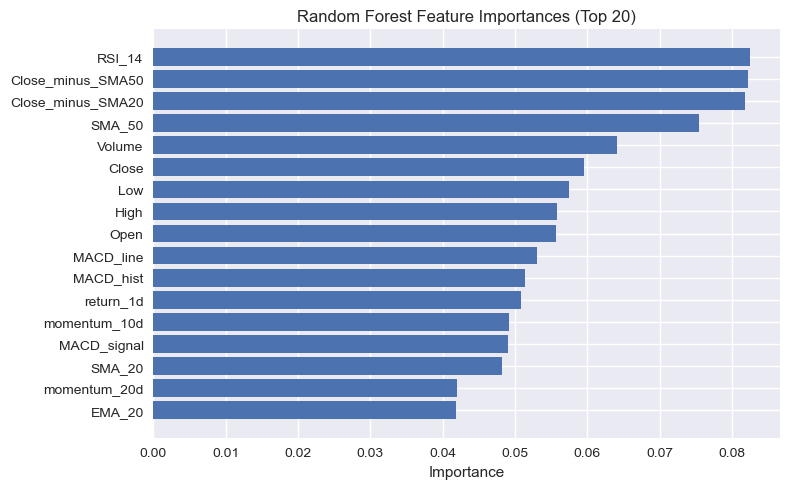

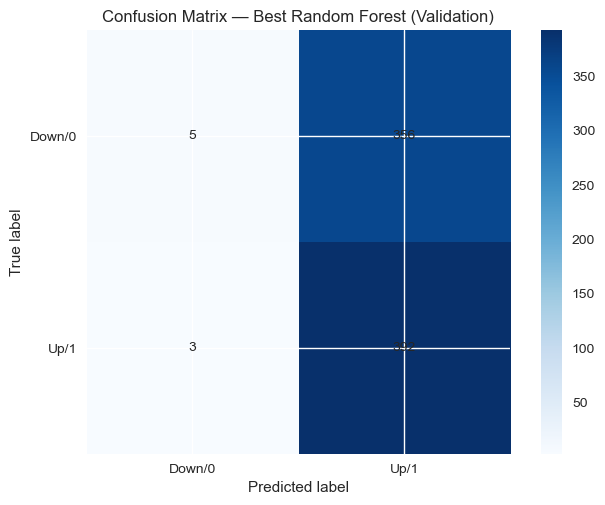

In [85]:
#Reuse the same data objects as previous sections
if "DF" not in globals():
    if "df_model" in globals():
        DF = df_model.copy()
    elif "data" in globals():
        DF = data.copy()
    else:
        raise NameError("Could not find modeling dataframe (`df_model` or `data`).")

TARGET = "target_direction"
if TARGET not in DF.columns:
    raise KeyError(f"Target column `{TARGET}` not found.")

if "feature_cols" not in globals():
    exclude = {TARGET, "target_return_1d"}
    feature_cols = [c for c in DF.columns if c not in exclude and pd.api.types.is_numeric_dtype(DF[c])]

if not all(name in globals() for name in ["train_df", "val_df", "test_df"]):
    # Default chronological split if not already created
    n = len(DF)
    train_end = int(n * 0.80)
    val_end   = int(n * 0.90)
    train_df = DF.iloc[:train_end].copy()
    val_df   = DF.iloc[train_end:val_end].copy()
    test_df  = DF.iloc[val_end:].copy()

X_train = train_df[feature_cols]
y_train = train_df[TARGET].astype(int)

X_val = val_df[feature_cols]
y_val = val_df[TARGET].astype(int)

print("Shapes:", X_train.shape, X_val.shape)
print("Train class balance:", y_train.value_counts(normalize=True).to_dict())


# 1) Baseline Random Forest
rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

t0 = time.perf_counter()
rf_base.fit(X_train, y_train)
train_time = time.perf_counter() - t0

t1 = time.perf_counter()
y_val_pred = rf_base.predict(X_val)
infer_time = time.perf_counter() - t1

acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

print("\n[Random Forest — Baseline (Validation)]")
print(f"Train time: {train_time:.4f}s | Inference time: {infer_time:.4f}s")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_val, y_val_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Random Forest (Validation)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Down/0", "Up/1"])
plt.yticks([0, 1], ["Down/0", "Up/1"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()


# Funnel approach: small hyperparameter sweep
grid = {
    "n_estimators": [200, 500],
    "max_depth": [3, 5, 10, None],
    "min_samples_leaf": [1, 5, 20]
}

rows = []
for n_est in grid["n_estimators"]:
    for depth in grid["max_depth"]:
        for leaf in grid["min_samples_leaf"]:
            model = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=depth,
                min_samples_leaf=leaf,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train, y_train)
            pred_val = model.predict(X_val)

            rows.append({
                "n_estimators": n_est,
                "max_depth": str(depth),
                "min_samples_leaf": leaf,
                "val_accuracy": accuracy_score(y_val, pred_val),
                "val_precision": precision_score(y_val, pred_val, zero_division=0),
                "val_recall": recall_score(y_val, pred_val, zero_division=0),
                "val_f1": f1_score(y_val, pred_val, zero_division=0)
            })

rf_results = pd.DataFrame(rows).sort_values("val_f1", ascending=False)
print("\nTop 10 configurations by validation F1:")
display(rf_results.head(10))

best_cfg = rf_results.iloc[0].to_dict()
print("\nBest configuration (by validation F1):", best_cfg)

#Retrain the best RF and analyze feature importance
best_rf = RandomForestClassifier(
    n_estimators=int(best_cfg["n_estimators"]),
    max_depth=None if best_cfg["max_depth"] == "None" else int(best_cfg["max_depth"]),
    min_samples_leaf=int(best_cfg["min_samples_leaf"]),
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

best_pred_val = best_rf.predict(X_val)
best_f1 = f1_score(y_val, best_pred_val, zero_division=0)
print(f"\nBest RF validation F1 (retrained): {best_f1:.4f}")

# Feature importances
imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 20 features by Random Forest importance:")
display(imp.head(20))


#plot top 20 importances
topk = 20
plt.figure(figsize=(8, 5))
plt.barh(imp.head(topk)["feature"][::-1], imp.head(topk)["importance"][::-1])
plt.title("Random Forest Feature Importances (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# Confusion matrix for best RF on validation
cm_best = confusion_matrix(y_val, best_pred_val)
plt.figure()
plt.imshow(cm_best, cmap="Blues")
plt.title("Confusion Matrix — Best Random Forest (Validation)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Down/0", "Up/1"])
plt.yticks([0, 1], ["Down/0", "Up/1"])
for (i, j), v in np.ndenumerate(cm_best):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()


# Classification — Gradient Boosting (Boosted Trees)

Shapes: (436, 17) (756, 17)
Train class balance: {1: 0.5596330275229358, 0: 0.44036697247706424}

[Gradient Boosting — Baseline (Validation)]
Train time: 1.1716s | Inference time: 0.0022s
Accuracy: 0.5066 | Precision: 0.5238 | Recall: 0.6127 | F1: 0.5648 | ROC-AUC: 0.5203

Classification report:
               precision    recall  f1-score   support

           0       0.48      0.39      0.43       361
           1       0.52      0.61      0.56       395

    accuracy                           0.51       756
   macro avg       0.50      0.50      0.50       756
weighted avg       0.50      0.51      0.50       756



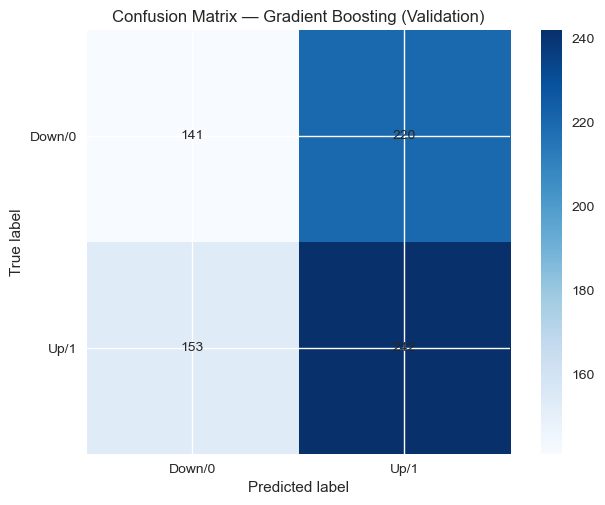

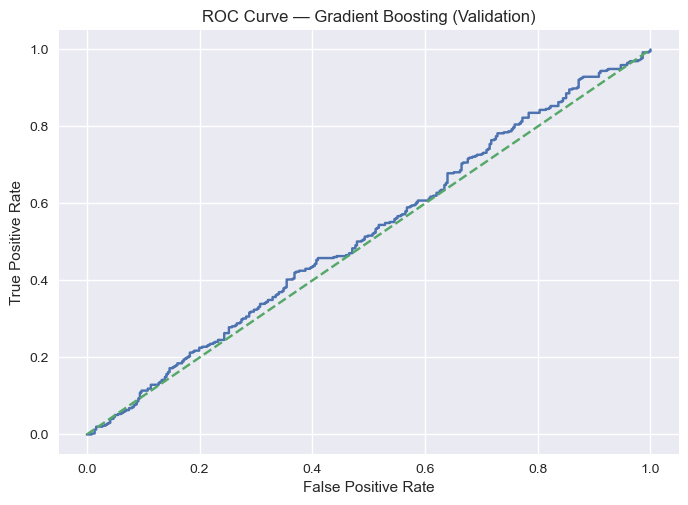


Top 10 configurations by validation F1 (then ROC-AUC):


,n_estimators,learning_rate,max_depth,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc
0,200,0.01,2,0.526455,0.534451,0.726582,0.615880,0.505635
2,200,0.01,4,0.518519,0.530452,0.683544,0.597345,0.491862
9,500,0.01,2,0.519841,0.531621,0.681013,0.597114,0.509422
1,200,0.01,3,0.522487,0.534413,0.668354,0.593926,0.507216
5,200,0.05,4,0.526455,0.538784,0.650633,0.589450,0.528416
11,500,0.01,4,0.517196,0.530488,0.660759,0.588501,0.504727
3,200,0.05,2,0.522487,0.536481,0.632911,0.580720,0.513970
6,200,0.10,2,0.507937,0.523810,0.640506,0.576310,0.514934
15,500,0.10,2,0.523810,0.540416,0.592405,0.565217,0.514738
4,200,0.05,3,0.506614,0.523810,0.612658,0.564761,0.520288



Best configuration: {'n_estimators': 200.0, 'learning_rate': 0.01, 'max_depth': 2.0, 'val_accuracy': 0.5264550264550265, 'val_precision': 0.5344506517690876, 'val_recall': 0.7265822784810126, 'val_f1': 0.6158798283261803, 'val_roc_auc': 0.5056348399312739}

Best GB — Validation F1: 0.6159 | ROC-AUC: 0.5056


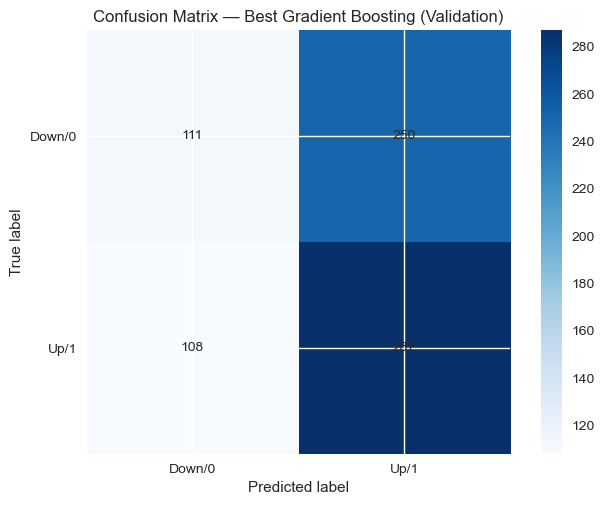

In [ ]:
# Gradient Boosting — Classification

#Reuse the same objects: DF, train_df/val_df/test_df, feature_cols
if "DF" not in globals():
    if "df_model" in globals():
        DF = df_model.copy()
    elif "data" in globals():
        DF = data.copy()
    else:
        raise NameError("Could not find modeling dataframe (`df_model` or `data`).")

TARGET = "target_direction"
if TARGET not in DF.columns:
    raise KeyError(f"Target column `{TARGET}` not found.")

if "feature_cols" not in globals():
    exclude = {TARGET, "target_return_1d"}
    feature_cols = [c for c in DF.columns if c not in exclude and pd.api.types.is_numeric_dtype(DF[c])]

if not all(name in globals() for name in ["train_df", "val_df", "test_df"]):
    n = len(DF)
    train_end = int(n * 0.80)
    val_end   = int(n * 0.90)
    train_df = DF.iloc[:train_end].copy()
    val_df   = DF.iloc[train_end:val_end].copy()
    test_df  = DF.iloc[val_end:].copy()

X_train = train_df[feature_cols]
y_train = train_df[TARGET].astype(int)

X_val = val_df[feature_cols]
y_val = val_df[TARGET].astype(int)

print("Shapes:", X_train.shape, X_val.shape)
print("Train class balance:", y_train.value_counts(normalize=True).to_dict())

# 1) Baseline Gradient Boosting
gb_base = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

t0 = time.perf_counter()
gb_base.fit(X_train, y_train)
train_time = time.perf_counter() - t0

t1 = time.perf_counter()
y_val_pred = gb_base.predict(X_val)
infer_time = time.perf_counter() - t1

# Probabilities for ROC-AUC
y_val_proba = gb_base.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)
auc = roc_auc_score(y_val, y_val_proba)

print("\n[Gradient Boosting — Baseline (Validation)]")
print(f"Train time: {train_time:.4f}s | Inference time: {infer_time:.4f}s")
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
print("\nClassification report:\n", classification_report(y_val, y_val_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Gradient Boosting (Validation)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Down/0", "Up/1"])
plt.yticks([0, 1], ["Down/0", "Up/1"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve — Gradient Boosting (Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# 2) Funnel approach: small hyperparameter sweep
grid = {
    "n_estimators": [200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

rows = []
for n_est in grid["n_estimators"]:
    for lr in grid["learning_rate"]:
        for md in grid["max_depth"]:
            model = GradientBoostingClassifier(
                n_estimators=n_est,
                learning_rate=lr,
                max_depth=md,
                random_state=42
            )
            model.fit(X_train, y_train)

            pred = model.predict(X_val)
            proba = model.predict_proba(X_val)[:, 1]

            rows.append({
                "n_estimators": n_est,
                "learning_rate": lr,
                "max_depth": md,
                "val_accuracy": accuracy_score(y_val, pred),
                "val_precision": precision_score(y_val, pred, zero_division=0),
                "val_recall": recall_score(y_val, pred, zero_division=0),
                "val_f1": f1_score(y_val, pred, zero_division=0),
                "val_roc_auc": roc_auc_score(y_val, proba)
            })

gb_results = pd.DataFrame(rows).sort_values(["val_f1", "val_roc_auc"], ascending=False)
print("\nTop 10 configurations by validation F1 (then ROC-AUC):")
display(gb_results.head(10))

best_cfg = gb_results.iloc[0].to_dict()
print("\nBest configuration:", best_cfg)


# 3) Retrain best model and re-evaluate on validation
best_gb = GradientBoostingClassifier(
    n_estimators=int(best_cfg["n_estimators"]),
    learning_rate=float(best_cfg["learning_rate"]),
    max_depth=int(best_cfg["max_depth"]),
    random_state=42
)
best_gb.fit(X_train, y_train)

best_pred = best_gb.predict(X_val)
best_proba = best_gb.predict_proba(X_val)[:, 1]

best_f1 = f1_score(y_val, best_pred, zero_division=0)
best_auc = roc_auc_score(y_val, best_proba)
print(f"\nBest GB — Validation F1: {best_f1:.4f} | ROC-AUC: {best_auc:.4f}")

cm_best = confusion_matrix(y_val, best_pred)
plt.figure()
plt.imshow(cm_best, cmap="Blues")
plt.title("Confusion Matrix — Best Gradient Boosting (Validation)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Down/0", "Up/1"])
plt.yticks([0, 1], ["Down/0", "Up/1"])
for (i, j), v in np.ndenumerate(cm_best):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()
